# Feature Consistency in Latin Comedy

In [1]:
# Imports

import re 
import html 
from collections import Counter

from cltk.corpus.readers import get_corpus_reader
from cltk.stem.latin.j_v import JVReplacer
from cltk.tokenize.word import WordTokenizer
from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer

import numpy as np
import pandas as pd
import sklearn.feature_extraction.text as text
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
# Text Analysis/NLP Tools

replacer = JVReplacer()
word_tokenizer = WordTokenizer('latin')
lemmatizer = BackoffLatinLemmatizer()

vectorizer = text.CountVectorizer(input='content')

In [3]:
# Get files

ll = get_corpus_reader(corpus_name = 'latin_text_latin_library', language = 'latin')
files = ll.fileids()

plautus_files = [file for file in files if 'plaut' in file]
terence_files = [file for file in files if 'ter.' in file]

print(plautus_files)
print(terence_files)

['plautus/amphitruo.txt', 'plautus/asinaria.txt', 'plautus/aulularia.txt', 'plautus/bacchides.txt', 'plautus/captivi.txt', 'plautus/cas.txt', 'plautus/cistellaria.txt', 'plautus/curculio.txt', 'plautus/epidicus.txt', 'plautus/menaechmi.txt', 'plautus/mercator.txt', 'plautus/miles.txt', 'plautus/mostellaria.txt', 'plautus/persa.txt', 'plautus/poenulus.txt', 'plautus/pseudolus.txt', 'plautus/rudens.txt', 'plautus/stichus.txt', 'plautus/trinummus.txt', 'plautus/truculentus.txt', 'plautus/vidularia.txt']
['ter.adel.txt', 'ter.andria.txt', 'ter.eunuchus.txt', 'ter.heauton.txt', 'ter.hecyra.txt', 'ter.phormio.txt']


In [4]:
# Get raw text

plautus_raws = [ll.raw(file) for file in plautus_files]
terence_raws = [ll.raw(file) for file in terence_files]

In [5]:
# Function for preprocessing texts

def preprocess(text):

    # Remove Latin Library-specific paratexts with regex
    
    remove_list = [r'\bThe Latin Library\b',
                   r'\bThe Classics Page\b',
                   r'\bPlautus\b',
                   r'\bTerence\b',
                   r'\b[A-Z]+\b\.',
                   r'\b[A-Z]+\b',
                  ]
    
    for pattern in remove_list:
        text = re.sub(pattern, '', text)
    
    # Remove first line
    text = text[text.find('\n'):]

    # Remove html entities and related html artifacts
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
    text = re.sub(r' \xa0 ', '    ', text)
        
    # Lowercase text
    text = text.lower()

    # Normalize text
    text = replacer.replace(text) #Normalize u/v & i/j
    
    # Remove punctuation with translate
    punctuation ="\"#$%&\'()+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    # Remove numbers
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    # Remove all space
    text = re.sub('\s+', ' ', text)
    
    return text.strip()

In [6]:
# Preprocess texts

plautus_edits = [preprocess(raw) for raw in plautus_raws]
terence_edits = [preprocess(raw) for raw in terence_raws]

In [7]:
# Get titles

plautus_titles = ['Pl. ' + file.replace('plautus/','').replace('.txt','').title() for file in plautus_files]
terence_titles = ['Ter. ' + file.replace('ter.','').replace('.txt','').title() for file in terence_files]
titles = plautus_titles + terence_titles

In [8]:
# Get tokens & lemmas

plautus_tokens = [word_tokenizer.tokenize(edit) for edit in plautus_edits]
terence_tokens = [word_tokenizer.tokenize(edit) for edit in terence_edits]

plautus_lemma_pairs = [lemmatizer.lemmatize(tokens) for tokens in plautus_tokens]    
terence_lemma_pairs = [lemmatizer.lemmatize(tokens) for tokens in terence_tokens]    

plautus_lemmas = [[item[1].replace('2','') for item in pairs] for pairs in plautus_lemma_pairs]
terence_lemmas = [[item[1].replace('2','') for item in pairs] for pairs in terence_lemma_pairs]
# NB: 'cum' is a combined lemma for both the preposition and conjunction

In [9]:
# Create lemmatized texts

plautus_lemmatized_texts = [" ".join(lemmas) for lemmas in plautus_lemmas]
terence_lemmatized_texts = [" ".join(lemmas) for lemmas in terence_lemmas]

## A note about the visualizations below

For an overview of the methods used below, see Allen Riddell's [*Text Analysis with Topic Models for the Humanities and Social Sciences*](https://liferay.de.dariah.eu/tatom/working_with_text.html), spec. the page ["Working with Text"](https://liferay.de.dariah.eu/tatom/working_with_text.html). The most important concepts here are cosine similarity and dimension reduction.

With respect to cosine similarity, we create a document-term matrix (or 'spreadsheet' of each play, their vocabularies, and their word frequencies) and calculate the cosine similarity between the resultant vector for each word. The assumption here is that similar texts will use similar vocabularies.

With respect to dimension reduction, each calculation of pairwise distance between two words in the vocabulary adds dimensionality, and since it is difficult (impossible?) to comprehend readily multiple dimensions, we want to reduce the number of dimensions being considered while retaining as much information about the pairwise distance between words. Here we use multidimensional scaling to reduce dimensionality to a number that is easy to visualize, namely two. So, Riddell: "A general approach to visualizing distances is to assign a point in a plane to each text, making sure that the distance between points is proportional to the pairwise distances we calculated." With each text assigned a point with a distance relative to every other text, these points can be plotted with x, y coordinates.

A second visualization based on the same distance calculations and dimension reduction is also included below, namely a dendrogram. Using a hierarchical clustering algorithm (here, Ward's method, a method where "the pooled within-group sum of squares is minimized"; see [here](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Hierarchical_Clustering-Dendrograms.pdf) each text as defined by its associated pairwise distance measurements is placed on the same "branch" as texts with low dissimilarity. So, Riddell: "Any clustering of texts should result in texts that are closer to each other (in the distance matrix) residing in the same cluster."

Concluding point: It is encouraging that the texts of Terence cluster together, but we do not want to place undue weight on this without more analysis. For now, this gives us a starting point for exploring the idea that there is likey sufficient author signal present from diction alone to think of "Terence" as a coherent idea separate from "Plautus".

In [10]:
# Create document term matrix

texts = plautus_lemmatized_texts + terence_lemmatized_texts
dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

In [11]:
# Compute Euclidean distance across the document-term matrix

dist = 1 - cosine_similarity(dtm)

# Reduce dimensionality to two components
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)

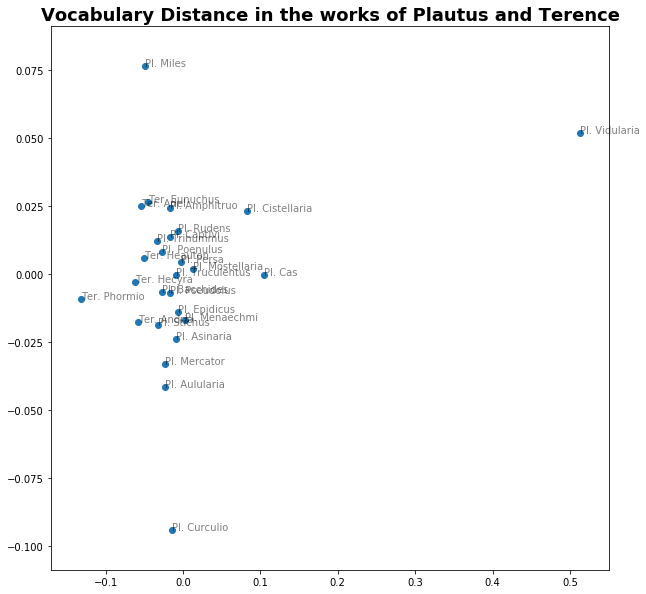

In [12]:
# Create scatterplot showing Euclidean distance

pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

plt.figure(figsize=(10,10))
plt.title('Vocabulary Distance in the works of Plautus and Terence', fontsize=18, fontweight='bold')
plt.scatter(xs, ys, cmap='spring')

for x, y, name in zip(xs, ys, titles):
    plt.text(x,y,name,alpha=0.5,fontsize=10)

plt.show()

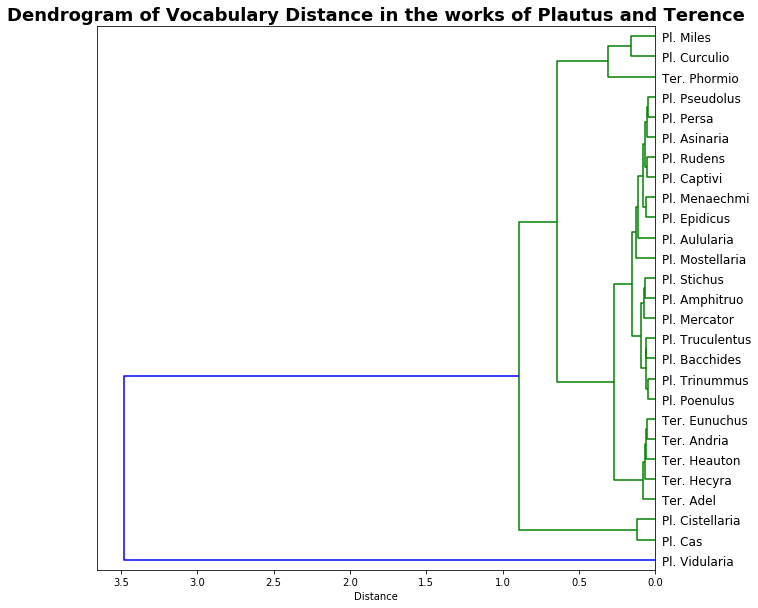

In [13]:
# Create dendrogram to distance

from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist)

texts = plautus_lemmatized_texts + terence_lemmatized_texts

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()

dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)

pos = mds.fit_transform(dist)
linkage_matrix = ward(dist)

plt.figure(figsize=(10,10))
plt.title('Dendrogram of Vocabulary Distance in the works of Plautus and Terence', fontsize=18, fontweight='bold')
plt.xlabel('Distance')

dendrogram(linkage_matrix, orientation="left", labels=titles, leaf_font_size=12);
plt.show()

At this exploratory stage, it may be worth considering whether we need to use the full vocabulary to determine author signal. Here are the same two visualizations run using only the 25 most frequent lemmas (listed below) for the two dramatists.

In [14]:
# Reduce number of features

top = 25 # limit lemmas to top x lemmas

plautus_lemmas_flat = [y for x in plautus_lemmas for y in x]
terence_lemmas_flat = [y for x in terence_lemmas for y in x]
lemmas_flat = plautus_lemmas_flat + terence_lemmas_flat
top_lemmas = [item[0] for item in Counter(lemmas_flat).most_common(top)]

plautus_lemmas_top = [[lemma for lemma in lemmas if lemma in top_lemmas] for lemmas in plautus_lemmas]
terence_lemmas_top = [[lemma for lemma in lemmas if lemma in top_lemmas] for lemmas in terence_lemmas]

plautus_lemmatized_top_texts = [" ".join(lemmas) for lemmas in plautus_lemmas_top]
terence_lemmatized_top_texts = [" ".join(lemmas) for lemmas in terence_lemmas_top]

In [15]:
print(top_lemmas)

['sum', 'ego', 'tu', 'hic', 'qui', 'is', 'quis', 'ut', 'facio', 'et', 'ille', 'in', 'si', 'non', 'meus', 'dico', 'cum', 'do', 'atque', 'nunc', 'ad', 'res', 'quam', 'uolo', 'iste']


In [16]:
# Create document term matrix and compute Euclidean distance

texts = plautus_lemmatized_top_texts + terence_lemmatized_top_texts

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

dist = 1 - cosine_similarity(dtm)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)

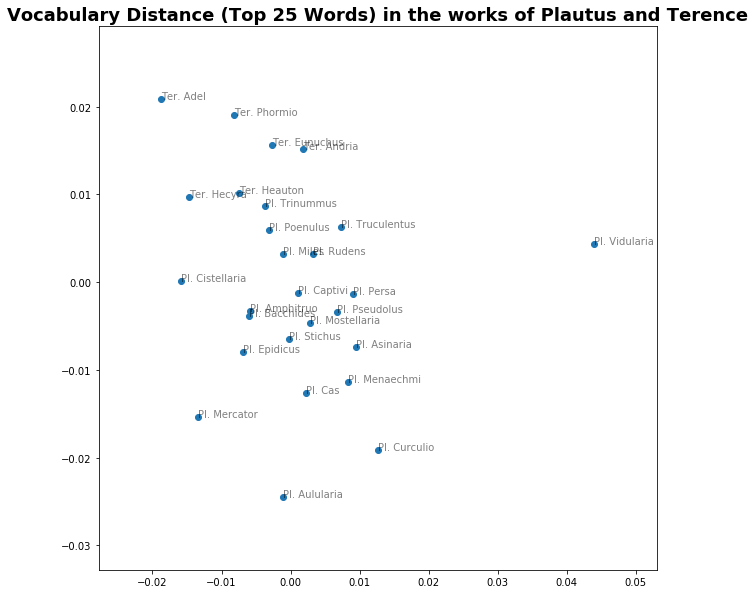

In [17]:
# Create scatterplot showing Euclidean distance

pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

plt.figure(figsize=(10,10))
plt.title(f'Vocabulary Distance (Top {top} Words) in the works of Plautus and Terence', fontsize=18, fontweight='bold')
plt.scatter(xs, ys, cmap='spring')
for x, y, name in zip(xs, ys, titles):
    plt.text(x,y,name,alpha=0.5,fontsize=10)
plt.show()

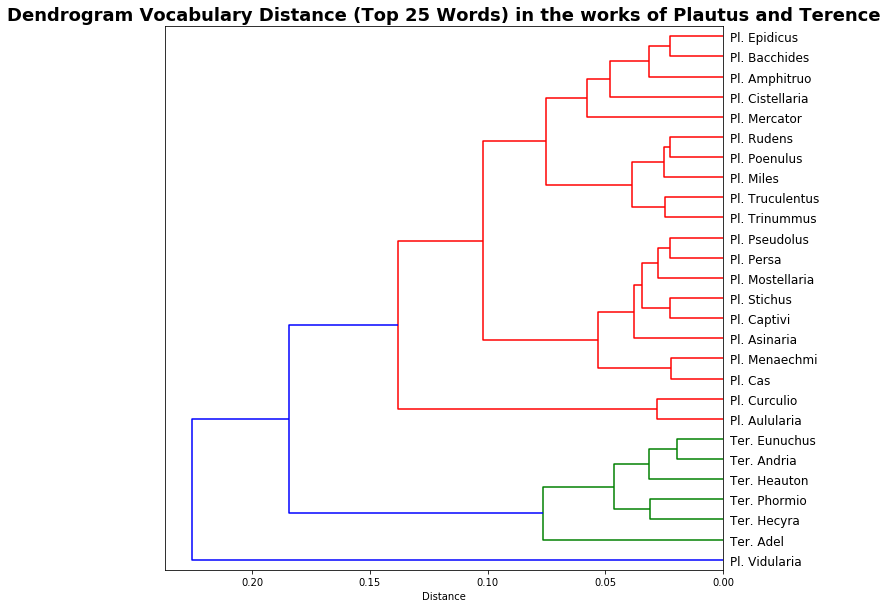

In [19]:
# Create dendrogram to show distance

from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist)

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()

dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(dist)
linkage_matrix = ward(dist)

plt.figure(figsize=(10,10))
plt.title(f'Dendrogram Vocabulary Distance (Top {top} Words) in the works of Plautus and Terence', fontsize=18, fontweight='bold')
plt.xlabel('Distance')
dendrogram(linkage_matrix, orientation="left", labels=titles, leaf_font_size=12);
plt.show()